<a href="https://colab.research.google.com/github/Rajaguhan437/Custom_GAN_to_CLIP/blob/main/GAN_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Downloading Libraries and dependenices

!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 
!pip install einops

# omegaconf ==> to load config files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00


In [3]:
## importing libraries

import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import yaml
from omegaconf import OmegaConf


# import warnings
# warnings.filterwarnings('ignore')


In [4]:
def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1, 2, 0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def norm_data(data):
  return (data.clip(-1, 1)+1)/2  ### range between 0 and 1 

In [5]:
### hyperparameters

lr = .5
batch_size = 1
weight_decay = .1
noise_factor = .1
device = "cuda"

total_iter = 100
im_shape = [225, 400, 3] # height, width, channel
size1, size2, channels = im_shape


In [6]:
### CLIP Model(connects texts with images) ==> Download

!git clone https://github.com/openai/CLIP.git

'''
# CLIP module is not in python path. So, 
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CLIP')
from CLIP import clip
'''
#!pip install CLIP
# from CLIP import Clip  ==> wrong way of import
from CLIP import clip # correct way

Cloning into 'CLIP'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 8.92 MiB | 12.63 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [7]:
### CLIP Model ==> Instantiation 

clipmodel, preprocess = clip.load("ViT-B/32", device=device, jit=False)
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution:", clipmodel.visual.input_resolution)

device = torch.device("cuda:0")
torch.cuda.empty_cache()

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 77.2MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution: 224


In [8]:
### Taming Transformer ==> Download 

!git clone https://github.com/CompVis/taming-transformers.git

### VQGan Arch ==> Download

%cd /content/taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/chkpts
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir("models/vqgan_imagenet_f16_16384/chkpts/")) == 0:
  !wget "https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1" -O "models/vqgan_imagenet_f16_16384/chkpts/last.ckpt"  

if len(os.listdir("models/vqgan_imagenet_f16_16384/configs/")) == 0:
  !wget "https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1" -O "models/vqgan_imagenet_f16_16384/configs/model.yaml"  

!pip uninstall torchtext --yes # otherwise results in error during from taming.models.vqgan import VQModel
!pip install --upgrade taming-transformers # otherwise results in torch._six import error
!pip install pytorch-lightning==1.0.0 # needed for vqgan transformer

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1339, done.
remote: Total 1339 (delta 0), reused 0 (delta 0), pack-reused 1339
Receiving objects: 100% (1339/1339), 409.77 MiB | 29.88 MiB/s, done.
Resolving deltas: 100% (280/280), done.
/content/taming-transformers
--2023-05-04 06:48:44--  https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/1268c11a-b865-42ec-980c-a7f8da8373a8/last.ckpt [following]
--2023-05-04 06:48:45--  https://heibox.uni-heidelberg.de/seafhttp/files/1268c11a-b865-42ec-980c-a7f8da8373a8/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [a

In [9]:
### taming-transformer(VQGan) Model ==> Instantiation 

from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
  config_data = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))
  return config_data

def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location='cpu')["state_dict"]
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()

def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/chkpts/last.ckpt").to(device)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:15<00:00, 36.6MB/s]


8.19kB [00:00, 371kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [26]:
### values that we are going to optimize to create beautiful images

class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters, self).__init__()
    self.data = .5*torch.randn(batch_size, 256, size1//16, size2//16).cuda() # 1 x 256 x 14 x 25
    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

def init_params():
  params = Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr':lr }], weight_decay = weight_decay)
  return params, optimizer

In [27]:
### Encodings the text

normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  t = clip.tokenize(text).cuda()
  t = clipmodel.encode_text(t).detach().clone()
  return t

def createEncodings(include, exclude, extras):
  include_enc = []
  for text in include:
    include_enc.append(encodeText(text))

  exclude_enc = encodeText(exclude) if exclude != '' else 0
  extras_enc = encodeText(extras) if exclude != '' else 0

  return include_enc, exclude_enc, extras_enc


In [28]:
### Image preprocess

augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)
).cuda()

torch.Size([1, 256, 14, 25])
img dimensions: torch.Size([1, 3, 224, 400])


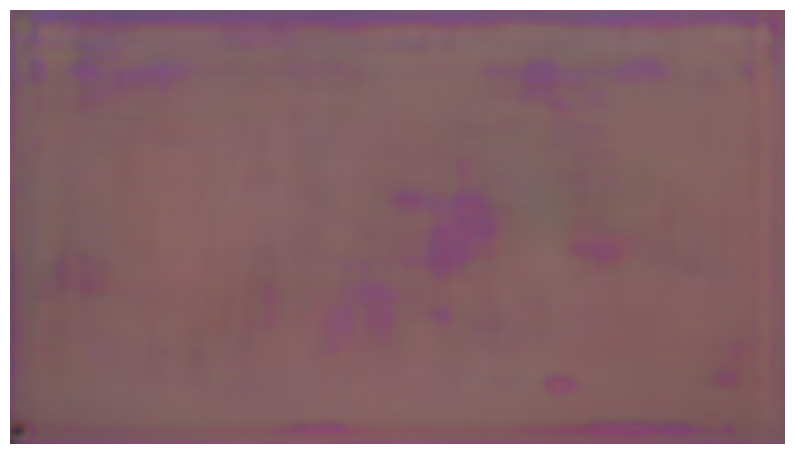

In [29]:
### Initiallize

Params,  optimizer = init_params()

with torch.no_grad():
  print(Params().shape)
  img = norm_data(generator(Params()).cpu()) # 1 x 3 x 224 x 400 [225 x 400]
  print("img dimensions:", img.shape)
  show_from_tensor(img[0])

In [30]:
### Image-preprocess

augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)  
).cuda()


### create crops

def create_crops(img, num_crops=30): 
  p=size1//2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 224x400)

  img = augTransform(img) #RandomHorizontalFlip and RandomAffine

  crop_set = []
  for ch in range(num_crops):
    gap1= int(torch.normal(1.0, .5, ()).clip(.2, 1.5) * size1)
    gap1= int(torch.normal(1.0, .5, ()).clip(.2, 1.5) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())

    crop=img[:, :, offsetx:offsetx+gap1, offsety:offsety+gap1]

    crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops=torch.cat(crop_set,0) ## 30 x 3 x 224 x 224
  img_crops = img_crops + noise_factor * torch.randn_like(img_crops, requires_grad=False)

  return img_crops

In [31]:
### Show current state of generation

def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float() # 1 x 3 x 224 x 400 
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen=norm_data(generated.cpu()) # 1 x 3 x 224 x 400
    show_from_tensor(latest_gen[0])

  return (latest_gen[0]) 

In [32]:
# Optimization process

def optimize_result(Params, prompt):
  alpha=1 ## the importance of the include encodings
  beta=.5 ## the importance of the exclude encodings

  ## image encoding
  out = generator(Params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out) # 30 x 3 x 224 x 224
  image_enc=clipmodel.encode_image(out) ## 30 x 512

  ## text encoding  w1 and w2
  final_enc = w1*prompt + w2*extras_enc # prompt and extras_enc : 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  ## calculate the loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [33]:
### training loop

def training_loop(Params, optimizer, show_crop=False):
  res_img=[]
  res_z=[]

  for prompt in include_enc:
    iteration=0
    Params, optimizer = init_params() # 1 x 256 x 14 x 25 (225/16, 400/16)

    for it in range(total_iter):
      loss = optimize(Params, optimizer, prompt)

      if iteration > 0 and iteration % (total_iter -1 ) == 0:
        new_img = showme(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params()) # 1 x 256 x 14 x 25
        print("loss:", loss.item(), "iteration:",iteration)

      iteration+=1
    torch.cuda.empty_cache()
  return res_img, res_z
  

Augmented cropped example


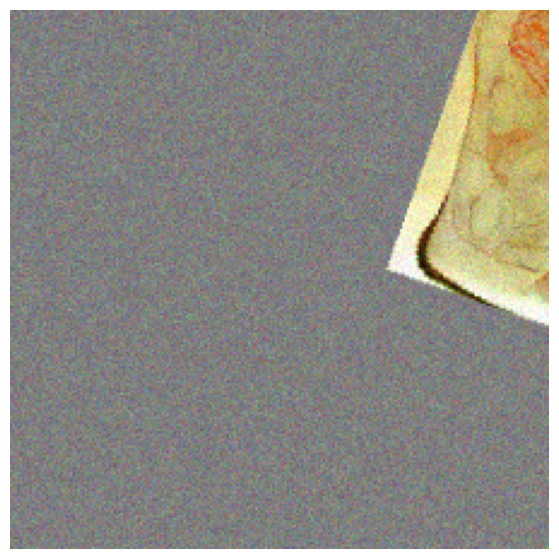

Generation


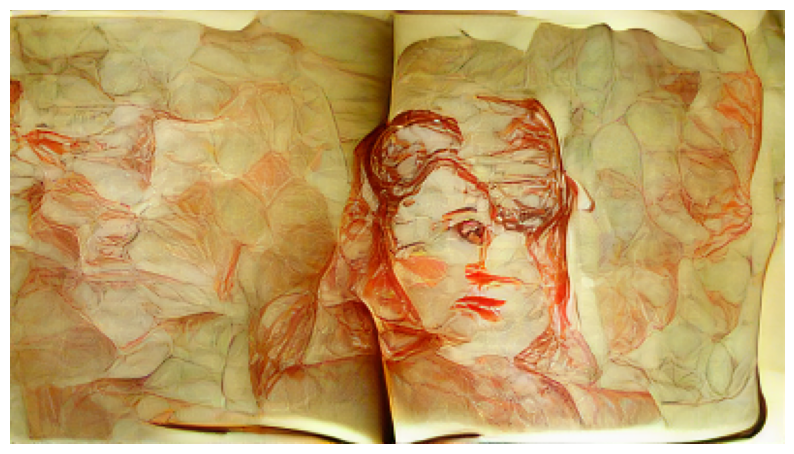

loss: -0.1912841796875 iteration: 99
Augmented cropped example


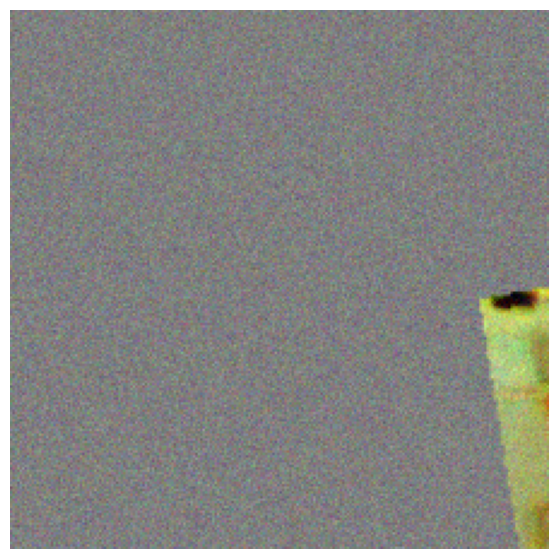

Generation


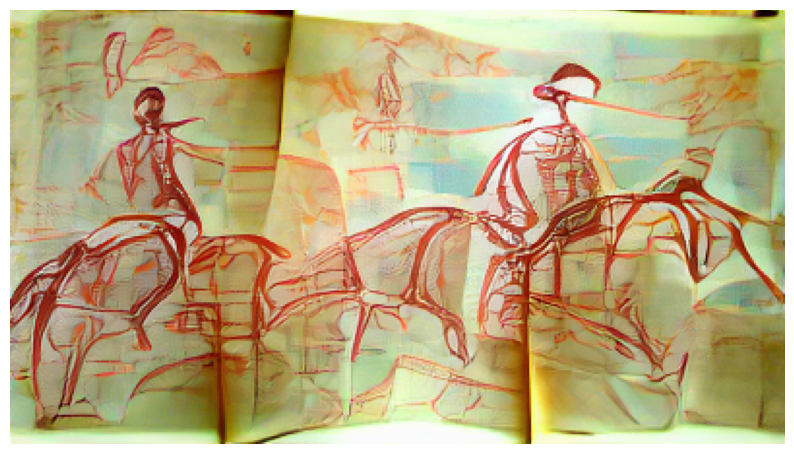

loss: -0.20849609375 iteration: 99


In [34]:
torch.cuda.empty_cache()

include = ['sketch of a lady', "sketch of a man on a horse"]
exclude = "watermark, cropped, confusing, incoherent, cut, blurry"
extras = "watercolur paper texture"

w1, w2 = 1, 1

include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z = training_loop(Params, optimizer, show_crop=True)

In [35]:
print(len(res_img), len(res_z))
print(res_img[0].shape, res_z[0].shape)
print(res_z[0].max(), res_z[0].min())

2 2
torch.Size([3, 224, 400]) torch.Size([1, 256, 14, 25])
tensor(6.4856, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-6.9614, device='cuda:0', grad_fn=<MinBackward1>)


In [39]:
### Video creation with interpolation

def interpolate(res_z_list, duration_list):
  gen_img_list = []
  fps =25

  for idx, (z, duration) in enumerate(zip(res_z_list, duration_list)):
    num_steps = int(duration*fps)
    z1 = z
    z2 = res_z_list[(idx+1)%len(res_z_list)] # 1 x 256 x 14 x 25

    for step in range(num_steps):
      alpha =  math.sin(1.5*step/num_steps)**6
      z_new = alpha * z2 + (1 - alpha) * z1

      new_gen = norm_data(generator(z_new).cpu())[0] ## 3 x 224 x 400
      new_img = T.ToPILImage(mode='RGB')(new_gen)
      gen_img_list.append(new_img)

  return gen_img_list

In [40]:
durations = [3, 5, 5, 4, 2, 4]
interp_result_img_list = interpolate(res_z, durations)

In [41]:
### creating video

out_video_path = "../res1.mp4"
writer = imageio.get_writer(out_video_path, fps=25)
for pil_img in interp_result_img_list:
  img = np.array(pil_img, dtype=np.uint8)
  writer.append_data(img)

writer.close()

In [44]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('../res1.mp4', 'rb').read()
data = "data:video/mp4;base64,"+b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" % data)